# ETL Pipeline KPI Dashboard (After the Pipeline)

This notebook analyzes performance indicators for the ETL pipeline.

It connects to PostgreSQL, extracts execution logs from Airflow metadata tables, and visualizes task durations, run counts, and statuses to evaluate pipeline reliability and overall performance.


### A. Environment setup

This section initializes the Python environment required for ETL monitoring.

We import analysis libraries like pandas and matplotlib, along with SQLAlchemy to access the database.

A connection is established to Airflow's PostgreSQL metadata database, which stores the history of DAG and task executions.

This connection allows us to extract execution metrics and analyze overall pipeline performance.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from common.config import SQLALCHEMY_URL

engine = create_engine(SQLALCHEMY_URL)
print("Connected to Airflow metadata successfully.")

Connected to Airflow metadata successfully.


### B. Loading Airflow metadata tables

In this section, we pull operational data from Airflow's internal tables:
- `dag_run`: records each DAG execution with start/end times and final status.
- `task_instance`: stores task history, durations, retries, and states.

Together, these tables provide a full view of the ETL pipeline, including runtimes, success rates, and restarts.
The data are loaded into pandas DataFrames for cleaning and analysis.


In [2]:
# Load DAG run data
dag_query = """
SELECT
    dag_id,
    start_date,
    end_date,
    state AS dag_status
FROM dag_run
WHERE dag_id = 'etl_multimodal_dag';
"""

# Load task instance data
task_query = """
SELECT
    dag_id,
    task_id,
    start_date,
    end_date,
    duration,
    state AS task_status,
    try_number
FROM task_instance
WHERE dag_id = 'etl_multimodal_dag';
"""

with engine.connect() as conn:
    dag_df = pd.read_sql(dag_query, conn.connection)
    task_df = pd.read_sql(task_query, conn.connection)

print(f"Loaded {len(dag_df)} DAG runs and {len(task_df)} task instances.")

Loaded 4 DAG runs and 20 task instances.


/tmp/ipykernel_11674/2478197707.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dag_df = pd.read_sql(dag_query, conn.connection)
/tmp/ipykernel_11674/2478197707.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  task_df = pd.read_sql(task_query, conn.connection)


### C. Data cleaning and preparation

Before analysis, raw data are prepared: timestamps are converted, durations are computed, and derived columns are created (run date, launch day, etc.).

This ensures that all metrics - like runtime and success rate - are consistent and usable.

Missing durations are recalculated when needed, and data types are aligned to enable reliable analysis and correct visualizations.


In [3]:
# Convert datetimes
for col in ["start_date", "end_date"]:
    task_df[col] = pd.to_datetime(task_df[col])

# Compute run duration if missing
if "duration" not in task_df or task_df["duration"].isnull().all():
    task_df["duration"] = (task_df["end_date"] - task_df["start_date"]).dt.total_seconds()

# Derive date for grouping
task_df["run_day"] = task_df["start_date"].dt.date

### D. Visualizing task statuses

This section computes and displays key performance indicators (KPIs) for each Airflow task:
- Success rate (in %)
- Average duration (seconds)
- Maximum retry count

These indicators are summarized in a table and visualized in charts to assess stability and efficiency for each pipeline step.

The results help identify the most stable tasks and those needing improvements.


In [4]:
# Success rate per task
success_rate = (
    task_df.groupby("task_id")["task_status"]
    .apply(lambda x: (x == "success").mean() * 100)
    .reset_index(name="success_rate")
)
# Average duration per task
avg_duration = (
    task_df.groupby("task_id")["duration"]
    .mean()
    .reset_index(name="avg_duration_sec")
)
# Retry count per task
retries = (
    task_df.groupby("task_id")["try_number"]
    .max()
    .reset_index(name="max_retries")
)
# Daily pipeline duration trend
daily_perf = (
    task_df.groupby("run_day")["duration"]
    .mean()
    .reset_index(name="avg_duration_sec")
)
# Merge summary KPIs
kpi_summary = (
    success_rate
    .merge(avg_duration, on="task_id", how="left")
    .merge(retries, on="task_id", how="left")
)

display(kpi_summary)

,task_id,success_rate,avg_duration_sec,max_retries
0,collect,100.0,2.394211,3
1,extract,100.0,20.454691,1
2,load,100.0,0.349958,4
3,seed_reference_data,100.0,0.332158,1
4,transform,100.0,0.326470,1


### E. Execution duration analysis

Here, average execution times for each task are analyzed to identify potential bottlenecks in the pipeline.

Bar charts compare runtimes across stages (collection, extraction, transformation, loading, etc.).

A second visualization shows the success rate for each task to compare reliability and performance.

These analyses make it easier to optimize the most time-consuming steps.


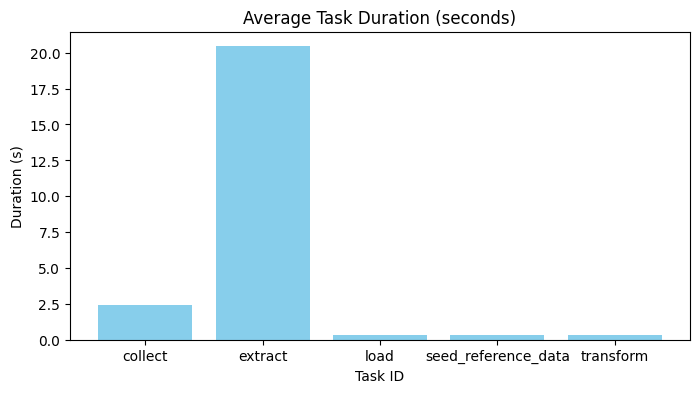

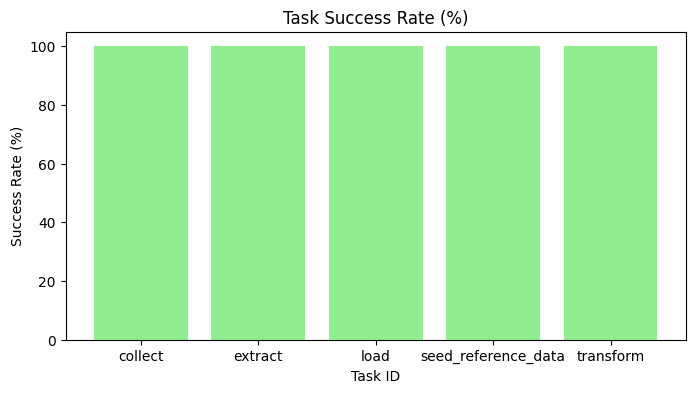

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(kpi_summary["task_id"], kpi_summary["avg_duration_sec"], color="skyblue")
plt.title("Average Task Duration (seconds)")
plt.xlabel("Task ID")
plt.ylabel("Duration (s)")
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(kpi_summary["task_id"], kpi_summary["success_rate"], color="lightgreen")
plt.title("Task Success Rate (%)")
plt.xlabel("Task ID")
plt.ylabel("Success Rate (%)")
plt.show()

### F. Optional alerts and thresholds

This section implements a simple alert system based on a predefined duration threshold.

Tasks whose runtime exceeds the threshold are flagged, helping detect performance degradation quickly.

This mechanism can be extended to real-time monitoring or integrated with external tools (Slack, Datadog, Airflow sensors, etc.).

In this local version, alerts are printed in the console for readability.


In [6]:
threshold = 120  # seconds
slow_tasks = kpi_summary[kpi_summary["avg_duration_sec"] > threshold]

if not slow_tasks.empty:
    print("Warning: The following tasks exceeded threshold duration:")
    display(slow_tasks)
else:
    print("All tasks executed within acceptable limits.")

All tasks executed within acceptable limits.


## Conclusion

This notebook provides an overview of ETL pipeline performance using Airflow metadata.

By tracking execution durations, success rates, and retry counts, it helps:
- identify recurring errors or slowdowns,
- verify pipeline reliability after deployment,
- improve overall stability and performance.

These results feed into the ETL monitoring dashboard and ongoing optimization.
